**Author:** Miranda Law

**Course:** COSC-355 Network Science

**Assignment:** HW5 Viral Propagation

**Last updated:** 12/04/2022

**Description:** We will simulate a toy version of a "market crash" caused by the collapse of the stock price of a company. Given that stock prices are interdependent, we will assume that if one company's stock value collapses, then there is a chance that the stock value of other companies may also collapse. The higher the interdependence between two companies, the higher the chances of this happening.

In [1]:
# Imports
import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tabulate import tabulate

### 1. Load node labels and edges

In [2]:
# Initialize empty dict for id: company name
id2name = {}

# Read in company names
with open("stocks_62_names.txt") as f:
    reader = csv.reader(f, delimiter=' ')
    for line in reader:
        id = line[0]
        name = line[1]
        id2name[id] = name

In [3]:
# Initialize list for the Pearson correlation b/w the prices of these stocks
# [[id1, id2, Pearson correlation b/w the prices of these stocks]]
edges = []

# Read in edges
with open("stocks_62_pearson.net.txt") as f:
    reader = csv.reader(f, delimiter=' ')
    for line in reader:
        edges.append(line)

### 2. Create and visualize this graph

In [4]:
# Create graph
graph = nx.Graph()

for e in edges:
    graph.add_edge(id2name[e[0]], id2name[e[1]], weight=float(e[2]))

In [5]:
"""
draw_weighted_graph(): visualize a weighted graph using networkx
    input:
        g - weighted networkx graph
        node_colors - a list of node colors
        label_color - color used for node labels
        pos (optional) - list of node positions
    output:
        dictionary of positions computed by spring_layout 
"""

def draw_weighted_graph(g, node_colors, label_color, pos={}):
    positions = pos
    if len(positions) == 0:
        positions = nx.spring_layout(g)

    nodes = nx.draw_networkx_nodes(g, pos=positions, node_color=node_colors)
    labels = nx.draw_networkx_labels(g, pos=positions, font_color=label_color)
    weights = [graph[u][v]['weight'] for u,v in graph.edges()]
    edges = nx.draw_networkx_edges(g, pos=positions, width=weights)

    plt.show()
    return positions

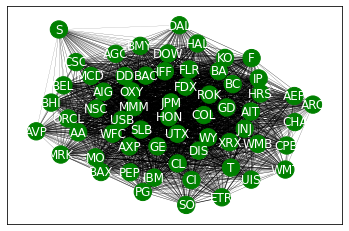

In [6]:
# get list of positions computed by `spring_layout`
p = draw_weighted_graph(graph, node_colors=['green' for u in graph.nodes()], label_color='white')

### 3. Simulate one propagation using the independent cascade model

In [8]:
"""
simulate_independent_cascade(): simulate independent cascades
    input:
        graph - weighted networkx graph
        starting_node - starting node for the infection
        weight_attr_name - name of edge attribute for weight
        weight_multiplier - way of interpreting the weights as probabilities
                if an edge weight is 0.8 and the weight multiplier is 0.5, 
                then transmission probability for this edge will be 0.4.
        infectedDict - an infected dictionary with every node having value False
    output:
        return the resulting infected dictionary
"""
def simulate_independent_cascade(graph, starting_node, weight_attr_name, weight_multiplier, infectedDict):
    
    # Mark a starting node u as infected with value True
    infectedDict[starting_node] = True

    # Keep track of infected neighbors
    infectedNeighbors = []

    # infect all uninfected neighbors of the starting node
    for n in graph.neighbors(starting_node):

        # if a neighbor is not infected
        if infectedDict[n] == False:
            r = random.random()
            pTransmission = graph[starting_node][n]["weight"] * weight_multiplier

            # infect node
            if r < pTransmission:
                infectedDict[n] = True
                infectedNeighbors.append(n)
    
    # recurse over infected neighbors
    for n in infectedNeighbors:
        simulate_independent_cascade(graph, n, weight_attr_name, weight_multiplier, infectedDict)

    return infectedDict

In [10]:
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='NSC', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

Infected nodes: 52


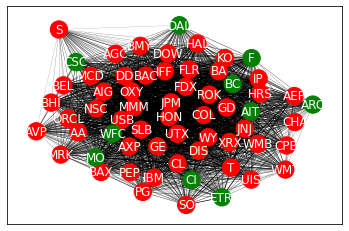

In [11]:
# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')

### 4. Compute the average size of the infection starting from a node

In [12]:
def infectionSim(graph, num_trials, starting_node):
    avgInfections = 0

    for i in range(0, num_trials):
        # Initialize an infected dictionary with every node having value False
        infected = dict([(node, False) for node in graph.nodes()])
        # simulate infection cascade
        infected = simulate_independent_cascade(graph, starting_node=starting_node, weight_attr_name='weight', 
                                                weight_multiplier=0.1, infectedDict=infected)
        # count infections
        infected_count = sum([1 for is_infected in infected.values() if is_infected])
        
        avgInfections += infected_count
    return avgInfections/num_trials

In [14]:
# compute average infection size per node
avgInfections = {}
for node in graph.nodes():
    avgInfections[node] = infectionSim(graph, 10000, node)

In [17]:
sortedAvgs = sorted(avgInfections.items(), key = lambda x: x[1], reverse = True)

In [18]:
print(tabulate(sortedAvgs, headers = ["Company", "Cascade Size (avg)"], tablefmt="grid"))

+-----------+----------------------+
| Company   |   Cascade Size (avg) |
+===========+======================+
| HON       |              45.2565 |
+-----------+----------------------+
| MMM       |              45.1125 |
+-----------+----------------------+
| WFC       |              44.803  |
+-----------+----------------------+
| UTX       |              44.6096 |
+-----------+----------------------+
| FLR       |              44.2734 |
+-----------+----------------------+
| USB       |              44.2639 |
+-----------+----------------------+
| AXP       |              44.2458 |
+-----------+----------------------+
| GE        |              44.2409 |
+-----------+----------------------+
| DD        |              44.1501 |
+-----------+----------------------+
| IFF       |              44.1437 |
+-----------+----------------------+
| GD        |              43.6184 |
+-----------+----------------------+
| DIS       |              43.491  |
+-----------+----------------------+
|

Infected nodes: 51


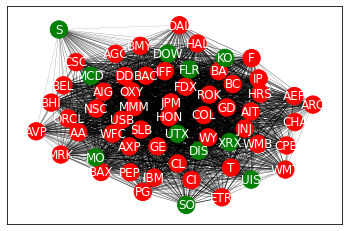

In [33]:
# most viral node graph 1
random.seed(1)
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='HON', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')

Infected nodes: 54


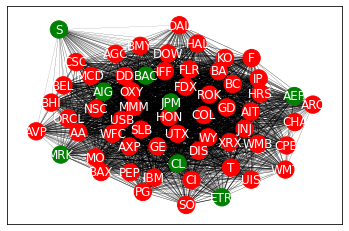

In [34]:
# most viral node graph 2
random.seed(2)
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='HON', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')

Infected nodes: 46


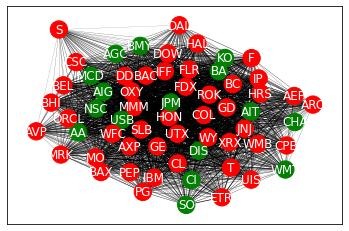

In [35]:
# most viral node graph 3
random.seed(3)
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='HON', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')

Infected nodes: 47


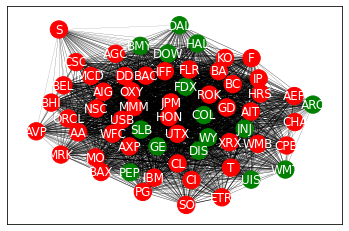

In [36]:
# most viral node graph 4
random.seed(4)
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='HON', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')

Infected nodes: 41


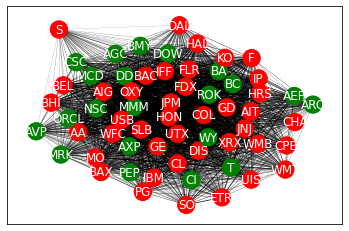

In [58]:
# least viral node graph 1
random.seed(11)
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='S', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')

Infected nodes: 48


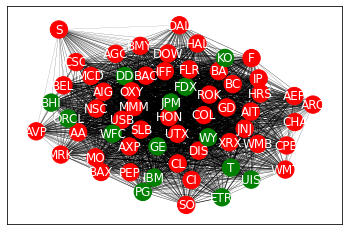

In [56]:
# least viral node graph 2
random.seed(12)
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='S', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')

Infected nodes: 1


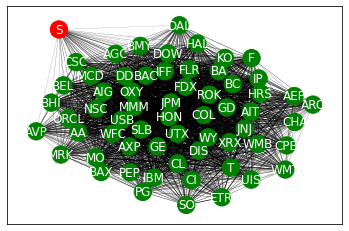

In [54]:
# least viral node graph 3
random.seed(13)
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='S', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')

Infected nodes: 1


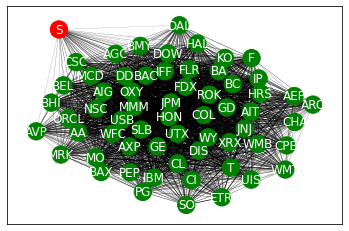

In [52]:
# least viral node graph 4
random.seed(14)
# Initialize an infected dictionary with every node having value False
infected = dict([(node, False) for node in graph.nodes()])

# simulate independent cascade
infected = simulate_independent_cascade(graph, starting_node='S', weight_attr_name='weight', 
                                        weight_multiplier=0.1, infectedDict=infected)

infected_count = sum([1 for is_infected in infected.values() if is_infected])
print("Infected nodes: %d" % infected_count)

# draw resulting graph
p = draw_weighted_graph(graph, pos=p, node_colors=[('red' if infected[u] else 'green') for u in graph.nodes()], 
                        label_color='white')